In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.stats as stats
import networkx as nx
import json

In [127]:
# This function takes as input n,k,sigma1,sigma2, and r
# It outputs a list x of length n*k (comprised of vectors in the plane)
# and a n*k by n*k matrix M
#
# The list is x made out of nk points in the plane generated from a Gaussian Mixture. 
# Concretely, we first sample k points distributed according to a 2D gaussian with mean 0 and variance sigma1^2
# and then for each of these k points one samples n points from a gaussian with mean at the point
# and variance sigma2
#
# The matrix M entries are all either 0 or 1,
# M[i,j] = 1 if distance between x[i] and x[j] is less than r
# M[i,j] = 0 otherwise
# 
def GenerateRandomGraph(n = 100, k = 4, sigma1 = 10, sigma2 = 1, r = 0.25):
    centers = stats.multivariate_normal.rvs(mean = [0,0], cov = sigma1*np.eye(2), size = k )
    x = {}
    for i in range(0,k):
        for j in range(0,n):
            x[i*n+j] = stats.multivariate_normal.rvs(mean = centers[i], cov = sigma2*np.eye(2))
    M = np.zeros((n*k,n*k))
    for i in range(n*k):
        for j in range(n*k):
            if i != j and la.norm(x[i]-x[j]) < r:
                M[i,j] = 1
                # It also might be interesting to have a weight
                # that is never larger than 1 but can be any number
                # between 0 and 1 according to the distance between 
                # x[i] and x[j]
                #M[i,j] = la.norm(x[i]-x[j]) 
    return x, M

# This function takes as input a networkx.graph object G
# and produces a n by n matrix (2d array)
# where matrix[i,j] is the graph distance in G from node i to node j
def graph_distance(graph):
    N = len(graph.nodes)
    
    matrix = np.empty((N,N))   
    print('Computing partial distance matrix with networkx')
    for i in range(N):
        for j in range(N):
            matrix[i,j] = nx.shortest_path_length(graph,source = i, target = j)
        # The following helps track how much is left to complete computation
        if (N-i)%10==0:
            print(N-i)        
            
    return matrix

def find_n_farthest_nodes(G, n):
    n = n-1
    # Compute the shortest path lengths between all pairs of nodes
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # Find the farthest pairs of nodes
    farthest_pairs = []

    for source, lengths in shortest_path_lengths.items():
        for target, length in lengths.items():
            if source < target:  # Avoid double counting pairs (source, target) and (target, source)
                farthest_pairs.append((length, (source, target)))

    # Step 4: Sort the pairs by distance in descending order and get the top n
    farthest_pairs.sort(reverse=True, key=lambda x: x[0])
    
    top_n_farthest = farthest_pairs[:n]

    return top_n_farthest

# Function to compute Euclidean distance between two nodes
def euclidean_distance(node1, node2):
    x1, y1 = G.nodes[node1]['pos']
    x2, y2 = G.nodes[node2]['pos']
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)



Computing partial distance matrix with networkx
Connect node 0 and node 10
Computing partial distance matrix with networkx
Connect node 0 and node 20
Computing partial distance matrix with networkx
40
30
20
10
Dist: [[0. 1. 1. ... 4. 4. 4.]
 [1. 0. 1. ... 5. 5. 5.]
 [1. 1. 0. ... 5. 5. 5.]
 ...
 [4. 5. 5. ... 0. 1. 1.]
 [4. 5. 5. ... 1. 0. 1.]
 [4. 5. 5. ... 1. 1. 0.]]
The shortest path from node 0 to node 5 is [0, 5] with a length of 0.2099656462916106.
farthest_nodes [(8, (26, 35)), (8, (29, 35))]
The nodes 26 and 35 are 8 units apart.
The nodes 29 and 35 are 8 units apart.


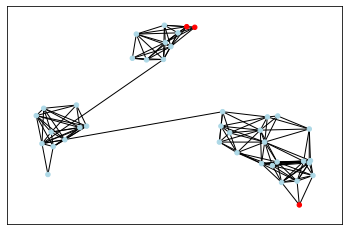

In [131]:
n = 10; k = 4; sigma1 = 2.5; sigma2 = 0.2; r = 1
x, M = GenerateRandomGraph(n, k, sigma1, sigma2, r)
#print("x:",x)
#print("M:",M)
try: # older versions of networkx
    G = nx.from_numpy_matrix(M)
except: # newer versions of networkx
    G = nx.from_numpy_array(M)
connectedGraph = False
connectionAttempts = 0

# Ensure graph is connected
while connectedGraph == False and connectionAttempts < 10:
    #print("G:",G)
    #print(G.adj)
    try:
        pos = nx.spring_layout(G)  # Using spring layout to assign positions for the nodes
        # Add positions as node attributes
        for node, coordinates in pos.items():
            G.nodes[node]['pos'] = coordinates
        # Compute the Euclidean distance for each edge and add it as an edge attribute
        for (u, v) in G.edges():
            distance = euclidean_distance(u, v)
            G.edges[u, v]['weight'] = distance
        dist = graph_distance(G)
        print("Dist:",dist)
        #target_node = 5
        # Initialize all nodes with a default color
        color_map = ['lightblue'] * len(G.nodes())
        # Set the color of the target node

        # Example: Finding the shortest path based on Euclidean distance
        source = 0
        target = 5
        shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
        shortest_path_length = nx.shortest_path_length(G, source=source, target=target, weight='weight')
        print(f"The shortest path from node {source} to node {target} is {shortest_path} with a length of {shortest_path_length}.")
        
        node_pairs = 3 # pairs of nodes farthest apart
        
        # Find and print the n farthest pairs of nodes
        farthest_nodes = find_n_farthest_nodes(G, node_pairs)
        print("farthest_nodes", farthest_nodes)
        for distance, (node1, node2) in farthest_nodes:
            print(f"The nodes {node1} and {node2} are {distance} units apart.")
            color_map[node1] = 'red'
            color_map[node2] = 'red'
            
        #color_map[target_node] = 'red'
        nx.draw_networkx_nodes(G,pos=x, node_size = 20, node_color=color_map)
        nx.draw_networkx_edges(G,pos=x)        
        plt.draw()
        connectedGraph = True
    except Exception as e:
        # graph isn't connected; identify nodes that are missing a path
        # from generated exception, e.g. No path between 0 and 3.
        error_str = str(e)
        error_str = error_str.replace("No path between ", "");
        error_str = error_str.replace(".", "");
        nodes = error_str.split(" and ")
        node0 = int(nodes[0])
        node1 = int(nodes[1])
        print("Connect node", node0, "and node", node1)
        G.add_edge(node0, node1)
        
    connectionAttempts = connectionAttempts + 1


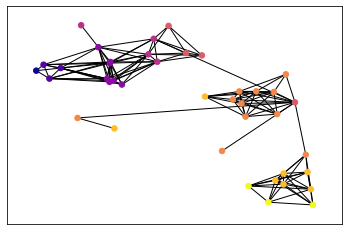

In [126]:
nx.draw_networkx_edges(G,pos=x)
node_color_dist = n * k - 1
#nx.draw_networkx_nodes(G,pos=x, node_size = 100, node_color = dist[80], cmap = 'plasma')
nx.draw_networkx_nodes(G,pos=x, node_size = 30, node_color = dist[node_color_dist], cmap = 'plasma')
plt.draw()


In [32]:
#This saves the distance function in a json file    
distance_file_path = "dist.json"

with open(distance_file_path, "w") as f:
    json.dump(dist.tolist(), f)

#This saves the vectors forming the vertices in a json file     
vertices_file_path = "vert.json"
vectors = np.array([item[1] for item in list(x.items())])        
with open(vertices_file_path, "w") as f:
    json.dump(vectors.tolist(), f)    